In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn import metrics, model_selection
import glob
import seaborn as sns

%matplotlib inline

import os
print(os.listdir("."))

/home/lazukav/anaconda3/lib/python3.5/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


['titanic_submit.ipynb', 'model5.ipynb', '.ipynb_checkpoints', 'model2.csv', 'test.csv', 'train.csv', 'titanic_submit-old_copy.ipynb', 'model4.csv', 'model3.ipynb', 'model2.ipynb', 'model3.csv', 'model4.ipynb', 'model1.csv', 'model1.ipynb', 'EDA.ipynb', 'model5.csv']


In [2]:
train = pd.DataFrame.from_csv('train.csv', index_col=0)
test = pd.DataFrame.from_csv('test.csv', index_col=0)
data_df = train.append(test)

/home/lazukav/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.
/home/lazukav/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  
/home/lazukav/anaconda3/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [3]:
data_df['Title'] = data_df['Name']

for name_string in data_df['Name']:
    data_df['Title'] = data_df['Name'].str.extract('([A-Za-z]+)\.', expand=True)

mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
data_df.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute = data_df.groupby('Title')['Age'].median()[titles.index(title)]
    data_df.loc[(data_df['Age'].isnull()) & (data_df['Title'] == title), 'Age'] = age_to_impute
    
train['Age'] = data_df['Age'][:891]
test['Age'] = data_df['Age'][891:]

train['Title'] = data_df['Title'][:891]
test['Title'] = data_df['Title'][891:]

data_df.drop('Title', axis = 1, inplace = True)

In [4]:
def proc_data(data):
    sex_mapping = {
        'male': 1,
        'female': 0
    }
    data['Sex'] = data['Sex'].map(sex_mapping)
    male_mean_age = data[data["Sex"]==1]["Age"].mean()
    female_mean_age = data[data["Sex"]==0]["Age"].mean()
    
    data.loc[ (data["Sex"]==1) & (data["Age"].isnull()), "Age"] = male_mean_age
    data.loc[ (data["Sex"]==0) & (data["Age"].isnull()), "Age"] = female_mean_age
    data.drop(['Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1, inplace=True)
    data = pd.get_dummies(data, columns=['Pclass'])
    data['Relatives'] = data['SibSp'] + data['Parch']

    return data

In [5]:
train = proc_data(train)

In [6]:
sex = tf.feature_column.numeric_column('Sex')
age = tf.feature_column.numeric_column('Age')
age_bucket = tf.feature_column.bucketized_column(age, [8, 16, 21, 32, 40, 55])
sibsp = tf.feature_column.numeric_column('SibSp')
parch = tf.feature_column.numeric_column('Parch')
pclass1 = tf.feature_column.numeric_column('Pclass_1')
pclass2 = tf.feature_column.numeric_column('Pclass_2')
pclass3 = tf.feature_column.numeric_column('Pclass_3')
relatives = tf.feature_column.numeric_column('Relatives')
titles = tf.feature_column.categorical_column_with_vocabulary_list(key='Title', vocabulary_list=['Mr', 'Mrs', 'Miss', 'Master', 'Rev', 'Dr'])
titles = tf.feature_column.indicator_column(titles)

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train.drop(['Survived'], axis=1), train['Survived'], test_size=0.2, shuffle=None)

In [9]:
def train_classification_model(
    learning_rate,
    steps,
    batch_size,
    X_train,
    y_train,
    X_test,
    y_test,
    cols,
    m_dir,
    periods):

    steps_per_period = steps / periods  

    training_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        shuffle=True,
    )

    ptraining_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_train,
        y=y_train,
        num_epochs=1,
        shuffle=False,
    )

    validation_input_fn = tf.estimator.inputs.pandas_input_fn(
        x=X_test,
        y=y_test,
        num_epochs=1,
        shuffle=False 
    )

    classifier = tf.estimator.BoostedTreesClassifier(
        feature_columns=cols,
        n_batches_per_layer=batch_size,
        n_classes=2,
        n_trees=20,
        model_dir=m_dir
    )

    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):

        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        classifier.evaluate(input_fn=validation_input_fn)

        training_predictions = list(classifier.predict(input_fn=ptraining_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id, 2)

        validation_predictions = list(classifier.predict(input_fn=validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id, 2)    
        print("Hey")

        training_log_loss = metrics.log_loss(y_train, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(y_test, validation_pred_one_hot)

        print("  period %02d : %0.2f" % (period, validation_log_loss))

        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
    print("Model training finished.")

    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    final_predictions = classifier.predict(input_fn=validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])


    accuracy = metrics.accuracy_score(y_test, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()

    cm = metrics.confusion_matrix(y_test, final_predictions)

    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return classifier

In [10]:
cols = [sex, pclass1, pclass2, pclass3, age_bucket, titles]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_every_n_hours': 10000, '_device_fn': None, '_evaluation_master': '', '_task_type': 'worker', '_protocol': None, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f91bce9cfd0>, '_save_summary_steps': 100, '_master': '', '_model_dir': '/tmp/model5', '_eval_distribute': None, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_global_id_in_cluster': 0, '_experimental_distribute': None, '_log_step_count_steps': 100, '_num_worker_replicas': 1, '_num_ps_replicas': 0, '_tf_random_seed': None, '_train_distribute': None, '_keep_checkpoint_max': 5, '_is_chief': True}
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Training model...
LogL

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-17-02:17:04
INFO:tensorflow:Saving dict for global step 0: accuracy = 0.6703911, accuracy_baseline = 0.6703911, auc = 0.5, auc_precision_recall = 0.66480446, average_loss = 0.6931473, global_step = 0, label/mean = 0.32960895, loss = 0.69314724, precision = 0.0, prediction/mean = 0.5, recall = 0.0
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 0: /tmp/model5/model.ckpt-0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model5/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
IN

INFO:tensorflow:Saving dict for global step 0: accuracy = 0.6703911, accuracy_baseline = 0.6703911, auc = 0.5, auc_precision_recall = 0.66480446, average_loss = 0.6931473, global_step = 0, label/mean = 0.32960895, loss = 0.69314724, precision = 0.0, prediction/mean = 0.5, recall = 0.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 0: /tmp/model5/model.ckpt-0
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model5/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model5/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Hey
  period 03 : 11.38
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model5/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Hey
  period 06 : 11.38
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model5/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tensorflow:Saving checkpoints for 0 into /tmp/model5/model.ckpt.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
INFO:tenso

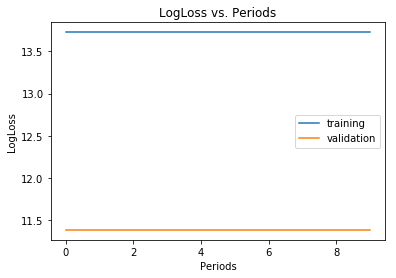

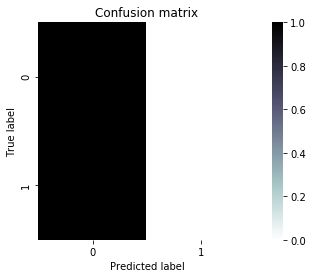

In [11]:
model5 = train_classification_model(
    learning_rate=0.01,
    steps=100,
    batch_size=20,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cols=cols,
    m_dir='/tmp/model5',
    periods=10)

In [12]:
scores5 = model5.predict(input_fn=tf.estimator.inputs.pandas_input_fn(x=proc_data(test),
                                                                      num_epochs=1,
                                                                      shuffle=False))

res = []
for i, p in enumerate(scores5):
    res.append([i + 892, p['class_ids'][0]])   

result = pd.DataFrame(res, columns=['PassengerId', 'Survived'])
result.to_csv('model5.csv', index=None)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/model5/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
